In [1]:
!pip install torch

In [2]:
import torch
import torch.nn as nn
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = "cpu"

In [3]:
save_dir = "diffusion training data/"
def load_transitions():
    import os.path
    if not os.path.isfile(save_dir + "observations.npz"):
        print("No saved transitions found")
        return()
    #its stored as a dict so grab out the single array. and 0th axis should be the number of transitions
    observations = np.load(save_dir + "observations.npz")["arr_0"]
    actions = np.load(save_dir + "actions.npz")["arr_0"]
    rewards = np.load(save_dir + "rewards.npz")["arr_0"]
    dones = np.load(save_dir + "dones.npz")["arr_0"]
    assert(len(observations) == len(actions) == len(rewards) == len(dones))
    print("loaded transitions of length", len(observations))


    #crashes on codespaces
    # observations = torch.tensor(observations, dtype=torch.float32, device=device)
    # actions = torch.tensor(actions, dtype=torch.float32, device=device)
    # rewards = torch.tensor(rewards, dtype=torch.float32, device=device)
    # dones = torch.tensor(dones, dtype=torch.float32, device=device)

    return observations, actions, rewards, dones

In [4]:
observations, actions, rewards, dones = load_transitions()
print(observations[0].size, actions[0].size, rewards[0].size, dones[0].size)

loaded transitions of length 15280
33600 1 1 1


In [5]:

#change bool in dones to floats
for i in range(len(dones)):
    dones[i] = dones[i].astype(float)
#change numpy nd arrays to lists
l_obs = []
l_actions = []
l_rewards = []
l_dones = []
for i in range(len(actions)):
    l_obs.append(observations[i])
    l_actions.append(actions[i])
    l_rewards.append(rewards[i])
    l_dones.append(dones[i])
#flatten the observations
for i in range(len(l_obs)):
    l_obs[i] = l_obs[i].flatten()


#create list to organize the training data. 
#data is a list of [inputs, labels]
data = [[],[]]
for i in range(len(l_obs)-2):
    input = np.concatenate((l_obs[i], l_obs[i+1], [l_actions[i+1]]))
    label = np.concatenate((l_obs[i+2], [l_rewards[i+2]], [l_dones[i+2]]))
    data[0].append(input)
    data[1].append(label)

#data too big, try smaller amount
data = [data[0][:100], data[1][:100]]
#convert to tensors
# for i in range(2):
#     data[i] = torch.tensor(data[i], dtype=torch.float32, device=device)

In [6]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Conv2d(in_channels = input_size, out_channels =hidden_size, kernel_size = 3, stride = 1, padding = 1)
        self.fc2 = nn.ConvTranspose2d(in_channels=hidden_size, out_channels=output_size, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Define the input, hidden, and output sizes
input_size = 2 * observations[0].size + actions[0].size #two screens of pong and the action taken on the last frame
hidden_size = 5 #arbitrary
output_size = observations[0].size + rewards[0].size + dones[0].size #one screen of pong + the reward + done

# Create an instance of the network
net = Net().to(device=device)


In [7]:
#see https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

# define loss function and optimizer
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)





In [8]:
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
#see https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        # self.img_labels = pd.read_csv(annotations_file)
        # self.img_dir = img_dir
        self.img_labels = data[1]
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        print(idx)
        # img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = data[0]
        label = data[1]
        # if self.transform:
        #     image = self.transform(image)
        # if self.target_transform:
        #     label = self.target_transform(label)
        return image, label
    

batch_size = 64
trainset = CustomImageDataset("","")
if __name__ == '__main__':
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False, num_workers=4)

In [9]:

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        print(i)
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

In [ ]:
PATH = './pong_gen.pth'
torch.save(net.state_dict(), PATH)

In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH))

In [ ]:
outputs = net(images)

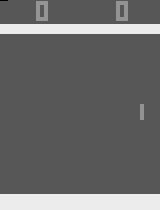

In [ ]:
from PIL import Image
image = Image.fromarray(observations[0])
image.show()

In [ ]:
gif = []
images = [Image.fromarray(observation) for observation in observations]
for image in images:
    gif.append(image)
gif[0].save('temp/result.gif', save_all=True,optimize=False, append_images=gif[1:], loop=0)